✅ Saved XGBoost model as xgb_model.pkl
✅ Saved grade comparison to grade_predictions_vs_actual.csv


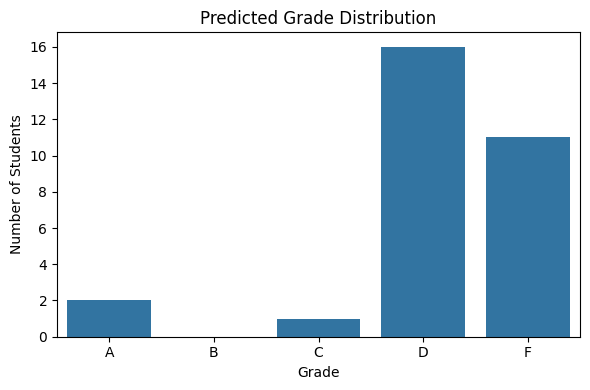

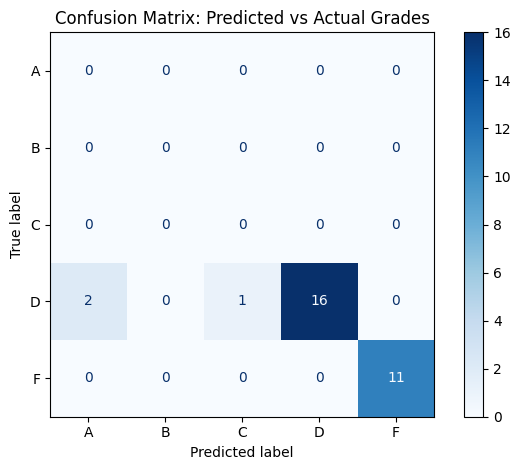


Mismatched predictions:
       Student_Id Actual Grade Predicted Grade
5   Candidate 333            D               C
20  Candidate 301            D               A
29  Candidate 302            D               A

Classification Report:
              precision    recall  f1-score   support

           A       0.00      0.00      0.00         0
           B       0.00      0.00      0.00         0
           C       0.00      0.00      0.00         0
           D       1.00      0.84      0.91        19
           F       1.00      1.00      1.00        11

    accuracy                           0.90        30
   macro avg       0.40      0.37      0.38        30
weighted avg       1.00      0.90      0.95        30


Overall Accuracy: 0.90


/Users/waqasii/My Mac/Masters in Applied Conputer Science/Thesis/Code/GradePredictionML/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/waqasii/My Mac/Masters in Applied Conputer Science/Thesis/Code/GradePredictionML/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/waqasii/My Mac/Masters in Applied Conputer Science/Thesis/Code/GradePredictionML/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defin

In [4]:
# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

# 📥 Load student-level feature dataset
df = pd.read_csv("../data/processed/student_features_with_scores.csv")  # Adjust path if needed

# 🎯 Separate features and target
X = df.drop(columns=["Student_Id", "Total Score"])
y = df["Total Score"]
student_ids = df["Student_Id"].reset_index(drop=True)  # Save for later

# 🧼 Impute missing values
imputer = SimpleImputer(strategy="mean")
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# ✂️ Split into train/test
X_train, X_test, y_train, y_test, student_ids_train, student_ids_test = train_test_split(
    X, y, student_ids, test_size=0.2, random_state=42
)

# 🤖 Train XGBoost Model
xgb_model = XGBRegressor(random_state=42, verbosity=0)
xgb_model.fit(X_train, y_train)

# 💾 Save the model
joblib.dump(xgb_model, "../models/xgb_model.pkl")
print("✅ Saved XGBoost model as xgb_model.pkl")

# 📈 Predict Scores
y_pred_scores = xgb_model.predict(X_test)

# 📘 Load original answer-level data
original_df = pd.read_csv("../data/processed/updated_data_with_points.csv")

# ✅ Step 1: Calculate max possible points per question
question_max = original_df.groupby("Question")["Assigned Points"].max().reset_index()
question_max.columns = ["Question", "Max Points"]

# ✅ Step 2: Merge with student answers to get max points per student
df_with_max = original_df.merge(question_max, on="Question", how="left")

# ✅ Step 3: Compute total possible points per student (based on questions they answered)
possible_scores = df_with_max.groupby("Student_Id")["Max Points"].sum().reset_index()
possible_scores.columns = ["Student_Id", "Possible Score"]

# ✅ Step 4: Assemble prediction results
results_df = pd.DataFrame({
    "Student_Id": student_ids_test.reset_index(drop=True),
    "Predicted Score": y_pred_scores
})
results_df = results_df.merge(possible_scores, on="Student_Id", how="left")

# ✅ Step 5: Calculate Percent Score
results_df["Percent Score"] = (results_df["Predicted Score"] / results_df["Possible Score"]) * 100

# ✅ Step 6: Grade Mapping

def score_to_grade(percent):
    if percent >= 85:
        return 'A'
    elif percent >= 70:
        return 'B'
    elif percent >= 55:
        return 'C'
    elif percent >= 40:
        return 'D'
    else:
        return 'F'

results_df["Predicted Grade"] = results_df["Percent Score"].apply(score_to_grade)

# ✅ Step 7: Add actual scores and compute actual percent + grade
actual_scores = pd.DataFrame({
    "Student_Id": student_ids_test.reset_index(drop=True),
    "Actual Score": y_test.reset_index(drop=True)
})

results_df = results_df.merge(actual_scores, on="Student_Id")
results_df["Actual Percent"] = (results_df["Actual Score"] / results_df["Possible Score"]) * 100
results_df["Actual Grade"] = results_df["Actual Percent"].apply(score_to_grade)

# 💾 Save comparison
results_df.to_csv("grade_predictions_vs_actual.csv", index=False)
print("✅ Saved grade comparison to grade_predictions_vs_actual.csv")

# 📊 Plot grade distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=results_df, x="Predicted Grade", order=["A", "B", "C", "D", "F"])
plt.title("Predicted Grade Distribution")
plt.xlabel("Grade")
plt.ylabel("Number of Students")
plt.tight_layout()
plt.show()

# 📊 Confusion Matrix: Predicted vs Actual Grades
cm = confusion_matrix(results_df["Actual Grade"], results_df["Predicted Grade"], labels=["A", "B", "C", "D", "F"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["A", "B", "C", "D", "F"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix: Predicted vs Actual Grades")
plt.tight_layout()
plt.show()

# 🧐 Show mismatched predictions
mismatches = results_df[results_df["Actual Grade"] != results_df["Predicted Grade"]]
print("\nMismatched predictions:")
print(mismatches[["Student_Id", "Actual Grade", "Predicted Grade"]].head())

# ✅ Model Accuracy Report
print("\nClassification Report:")
print(classification_report(results_df["Actual Grade"], results_df["Predicted Grade"], labels=["A", "B", "C", "D", "F"]))

accuracy = accuracy_score(results_df["Actual Grade"], results_df["Predicted Grade"])
print(f"\nOverall Accuracy: {accuracy:.2f}")
